<a href="https://colab.research.google.com/github/olusipedaniel/zero-to-mastery-exercises/blob/main/06_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.
2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?
3. Recreate the first model (the feature extraction model) with mixed_precision turned on.
 * Does it make the model train faster?
 * Does it effect the accuracy or performance of our model?
 * What's the advatanges of using mixed_precision training?

### 2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

In [1]:
# Importing tensorflow
import tensorflow as tf
tf.__version__

'2.8.2'

### Downloading and unzipping data

In [2]:
# Downloading data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# Unzipping data
import zipfile
zip_ref=zipfile.ZipFile("101_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-07-19 22:22:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  72.7MB/s    in 21s     

2022-07-19 22:22:37 (75.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [3]:
# Setting up target directory
train_dir="101_food_classes_10_percent/train"
test_dir="101_food_classes_10_percent/test"

In [4]:
# Setting up data inputs and packing them into batches 
IMG_SIZE=[224,224]
train_data=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE,
                                                              shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [5]:
# Getting class_names
class_names=train_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

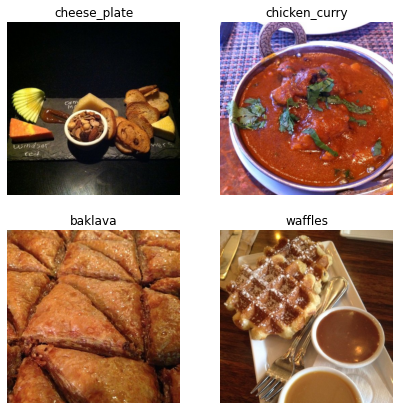

In [6]:
# Visualizing random images from train_data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random 

plt.figure(figsize=(7,7))
for i in range(4):
  plt.subplot(2,2,i+1)
  target_class=random.choice(class_names)
  target_dir=train_dir+"/"+target_class
  target_file=random.choice(os.listdir(target_dir))
  filename=target_dir+"/"+target_file

  img=mpimg.imread(filename)
  plt.imshow(img)
  plt.title(target_class)
  plt.axis(False)

In [7]:
# Creating data augmentation layer
data_augmentation=tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomRotation(0.2)
])

In [8]:
# Creating a non-trainable base_model
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Creating a functional model
input_shape=(224,224,3)
inputs=tf.keras.layers.Input(shape=input_shape)
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
outputs=tf.keras.layers.Dense(len(train_data.class_names),activation="softmax")(x)
model=tf.keras.Model(inputs,outputs)

# Compiling model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics="accuracy")

# Fitting model
history=model.fit(train_data,
                  epochs=10,
                  steps_per_epoch=len(train_data),
                  validation_data=test_data,
                  validation_steps=len(test_data)) 

16719872/16705208 [==============================] - 1s 0us/step
Epoch 1/10
237/237 [==============================] - 133s 491ms/step - loss: 3.4900 - accuracy: 0.2430 - val_loss: 2.4422 - val_accuracy: 0.4499
Epoch 2/10
237/237 [==============================] - 104s 439ms/step - loss: 2.3673 - accuracy: 0.4550 - val_loss: 2.0087 - val_accuracy: 0.5116
Epoch 3/10
237/237 [==============================] - 96s 404ms/step - loss: 2.0139 - accuracy: 0.5267 - val_loss: 1.8475 - val_accuracy: 0.5309
Epoch 4/10
237/237 [==============================] - 94s 395ms/step - loss: 1.7953 - accuracy: 0.5646 - val_loss: 1.7679 - val_accuracy: 0.5445
Epoch 5/10
237/237 [==============================] - 90s 381ms/step - loss: 1.6424 - accuracy: 0.5955 - val_loss: 1.7195 - val_accuracy: 0.5506
Epoch 6/10
237/237 [==============================] - 89s 375ms/step - loss: 1.5162 - accuracy: 0.6285 - val_loss: 1.6850 - val_accuracy: 0.5543
Epoch 7/10
237/237 [==============================] - 86s 362ms

In [9]:
# Evaluating model
model.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.6334 - accuracy: 0.5643


[1.6334335803985596, 0.5643168091773987]

The model (created in the notebook) which used feature extraction for 5 epochs and fine-tuning for 5 epochs had a accuracy of ~57% which slightly out performs the feature-extraction transfer learning model which trained for 10 epochs with an accuracy of ~56%.

### 3. Recreate the first model (the feature extraction model) with mixed_precision turned on.


In [10]:
# Importing mixed precision
from tensorflow.keras import mixed_precision

# Setting up mixed precision training
mixed_precision.set_global_policy("mixed_float16")
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


<Policy "mixed_float16">

In [11]:
# Creating a non-trainable mixed_precision base model 
mp_base_model=tf.keras.applications.EfficientNetB0(include_top=False)
mp_base_model.trainable=False

# Creating functional model
input_shape=(224,224,3)
inputs=tf.keras.layers.Input(shape=input_shape)
x=base_model(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(len(class_names))(x)
outputs=tf.keras.layers.Activation("softmax",dtype=tf.float32,name="softmax_float_32")(x)
mp_model=tf.keras.Model(inputs,outputs)

# Compiling mixed_precision model
mp_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics="accuracy")

# Fitting mixed_precision model
mp_history=mp_model.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
237/237 [==============================] - 76s 296ms/step - loss: 3.1571 - accuracy: 0.3192 - val_loss: 2.1843 - val_accuracy: 0.5100
Epoch 2/10
237/237 [==============================] - 69s 290ms/step - loss: 1.8626 - accuracy: 0.5843 - val_loss: 1.7915 - val_accuracy: 0.5654
Epoch 3/10
237/237 [==============================] - 69s 291ms/step - loss: 1.4493 - accuracy: 0.6690 - val_loss: 1.6481 - val_accuracy: 0.5837
Epoch 4/10
237/237 [==============================] - 69s 290ms/step - loss: 1.2039 - accuracy: 0.7288 - val_loss: 1.5817 - val_accuracy: 0.5902
Epoch 5/10
237/237 [==============================] - 69s 292ms/step - loss: 1.0250 - accuracy: 0.7761 - val_loss: 1.5374 - val_accuracy: 0.5978
Epoch 6/10
237/237 [==============================] - 69s 289ms/step - loss: 0.8842 - accuracy: 0.8168 - val_loss: 1.5104 - val_accuracy: 0.6014
Epoch 7/10
237/237 [==============================] - 69s 292ms/step - loss: 0.7701 - accuracy: 0.8483 - val_loss: 1.4933 - val_ac

In [12]:
# Evaluating mixed_precision model
mp_model.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.4783 - accuracy: 0.6082


[1.4782507419586182, 0.6081584095954895]

In [13]:
# Checking the dtype_policy in the mixed_policy base model
for num,layer in enumerate(mp_base_model.layers):
  print(num,layer.name,layer.trainable,layer.dtype_policy)

0 input_3 False <Policy "float32">
1 rescaling_1 False <Policy "mixed_float16">
2 normalization_1 False <Policy "mixed_float16">
3 stem_conv_pad False <Policy "mixed_float16">
4 stem_conv False <Policy "mixed_float16">
5 stem_bn False <Policy "mixed_float16">
6 stem_activation False <Policy "mixed_float16">
7 block1a_dwconv False <Policy "mixed_float16">
8 block1a_bn False <Policy "mixed_float16">
9 block1a_activation False <Policy "mixed_float16">
10 block1a_se_squeeze False <Policy "mixed_float16">
11 block1a_se_reshape False <Policy "mixed_float16">
12 block1a_se_reduce False <Policy "mixed_float16">
13 block1a_se_expand False <Policy "mixed_float16">
14 block1a_se_excite False <Policy "mixed_float16">
15 block1a_project_conv False <Policy "mixed_float16">
16 block1a_project_bn False <Policy "mixed_float16">
17 block2a_expand_conv False <Policy "mixed_float16">
18 block2a_expand_bn False <Policy "mixed_float16">
19 block2a_expand_activation False <Policy "mixed_float16">
20 block2a_

* Does it make the model train faster?

Yes, it saved us some minutes

* Does it effect the accuracy or performance of our model?

Yes, the val_accuracy increased by ~5%

* What's the advatanges of using mixed_precision training?

The advantage of mixed_precision training is that it helps to reduce the time consumed during training.